In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Homework №1

    In this homework you will need to implement the following stuff:
        1) Discrete Fourier Transform
        2) Fast Fourier Transform
        3) Compare by performance
        4) Short-time Fourier Transform based on (2) and hann window function
        5) MelScale
        6) Digit classification based on you melspectrograms
        
    Note:
        You should test your implementation with torchaudio functions
        (e.g. torch.allclose(torchaudio.transforms.Spectrogram.__call__, your_function))

### Main rules
    1) All operations must be implemented with pytorch (don't use numpy)
    2) Everything should support batch input
    3) No cycles, only matrix multiplications
    4) Clean and clear code 

In [1]:
!pip install torchaudio
!pip install torchvision

     |████████████████████████████████| 6.7MB 6.3MB/s 


In [2]:
import torch
import torchaudio
import torchvision
import matplotlib.pyplot as plt
from math import pi
import math
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from itertools import islice
import random

# Discrete Fourier Transform (1 pts)

In [4]:
# TODO
wav_file = '/content/audio.wav'
wav, sr = torchaudio.load(wav_file)
sample_len = 1024
wav = wav[:, : sample_len]
n, m = wav.shape
print(wav.shape)
print(sr)

torch.Size([1, 1024])
22050


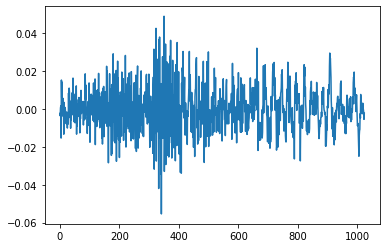

In [5]:
plt.plot(wav.squeeze());

torch.Size([1, 513, 2])


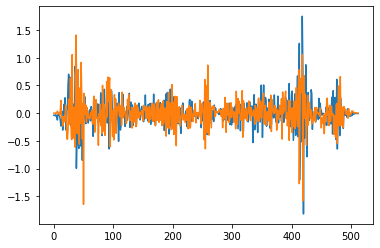

In [6]:
def dft(wav, onesided=True):
  wav = wav.squeeze().type(torch.cfloat)
  n = wav.shape[0]
  m = n // 2 + 1 if onesided else n
  i = torch.arange(n).expand((m, n))
  j = torch.arange(m).reshape(-1, 1).expand((m, n))
  pow = (i * j) % n
  M = torch.exp((-2 * pi * 1j * pow) / n)
  transformed = torch.view_as_real(torch.mv(M, wav)).unsqueeze(0)
  return transformed
  

print(dft(wav).shape)
plt.plot(dft(wav).squeeze());

torch.Size([1, 513, 2])


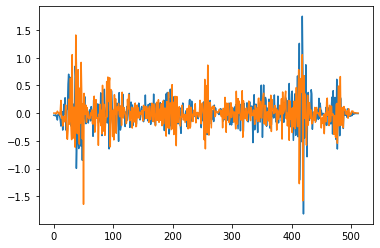

In [7]:
print(torch.rfft(wav, signal_ndim=1, ).shape)
plt.plot(torch.rfft(wav, signal_ndim=1).squeeze(0));

### Sanity Check

In [8]:
wav_file = 'audio.wav'
wav, sr = torchaudio.load(wav_file)
wav = wav[:, : sample_len]

torch.allclose(
    torch.rfft(wav, signal_ndim=1),
    dft(wav),
    atol=0.000001
)

True

# Fast Fourier Transform (3pts)

    A common task for machine learning engineer is to take an paper and implement it.
    So, just do it!
[Tap on me](http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf)
    

In [9]:
def make_pwr_of_two(n):
    return 2**math.ceil(math.log2(n))
  
def combine(g, h, w):
  return torch.cat((g, g)) + torch.cat((w, -w)) * torch.cat((h, h))

def fft_rec(f, n):
    even = torch.arange(0, n, 2)
    odd = torch.arange(1, n, 2)
    pow = torch.tensor([-1j * 2 * pi / n])
    n = n // 2
    mult = torch.arange(n) 
    if n == 1:
      g = torch.cat((f[0], f[0]))
      h = torch.cat((f[1], f[1]))
      w = torch.exp(torch.tensor([0, -1j * pi]))
      return g + w * h
    g = fft_rec(f[even], n)
    h = fft_rec(f[odd], n)
    w = torch.exp(pow * mult)
    return combine(g, h, w)


def fft_cyc(f, n):
    f = f.reshape(-1)
    width = n // 2  # width
    height = 2 # height
    dft_2 = torch.exp(torch.tensor([[0, -1j * pi]])).reshape(-1)
    lwr_lvl_pairs = torch.stack([f[: width], f[width :]], dim=1).type(torch.cfloat)
    lwr_lvl_ft = torch.stack([lwr_lvl_pairs.sum(dim=1), torch.mv(lwr_lvl_pairs, dft_2)])
    ft = lwr_lvl_ft
    while width > 1:
      mult = torch.arange(height) 
      width = width // 2
      height *= 2
      pow = torch.tensor([-1j * 2 * pi / height])
      g = ft[:, : width]
      h = ft[:, width : ]
      w = torch.exp(pow * mult).reshape(-1, 1).expand(height // 2, width)
      ft = combine(g, w, h)
    return ft.squeeze()


def fft(waw, fft_method=fft_cyc, onesided=True):
  waw = waw.squeeze()
  initial_n = waw.shape[0]
  n = make_pwr_of_two(initial_n)
  waw = F.pad(waw, (0, n - initial_n), "constant", 0).reshape(-1, 1)
  transformed = torch.view_as_real(fft_method(waw, n))
  if onesided:
    transformed = transformed[: initial_n // 2 + 1]
  return transformed.unsqueeze(0)

torch.Size([1, 513, 2])


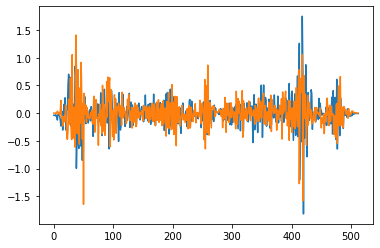

In [10]:
print(fft(wav, fft_cyc).shape)
plt.plot(fft(wav, fft_cyc).squeeze());

torch.Size([1, 513, 2])


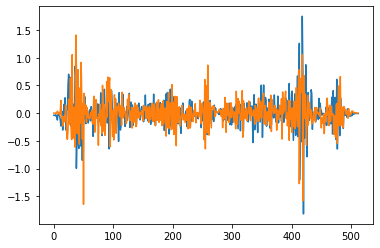

In [11]:
print(fft(wav, fft_rec).shape)
plt.plot(fft(wav, fft_rec).squeeze(0));

torch.Size([1, 513, 2])


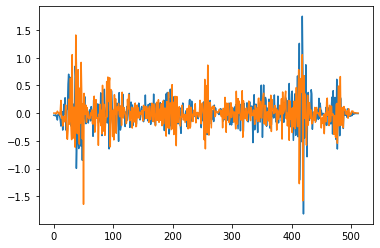

In [12]:
print(torch.rfft(wav, signal_ndim=1).shape)
plt.plot(torch.rfft(wav, signal_ndim=1).squeeze(0));

In [13]:
wav_file = 'audio.wav'
wav, sr = torchaudio.load(wav_file)

wav = wav[:, : sample_len]

torch.allclose(
    torch.rfft(wav, signal_ndim=1),
    fft(wav, fft_cyc),
    atol=0.00001
)

True

# A comparison of the performance (1e-7 pts)
    Do pretty images :)

In [14]:
%%timeit

dft(wav)

100 loops, best of 3: 13.5 ms per loop


Сначала написала рекурсию, но с ней просто ft, а не fast( 
(но уже не нужно хранить матрицу (n // 2) x n, так что он может медленно но верно обработать необрезанную wav-ку)

In [15]:
%%timeit

fft(wav, fft_rec)

10 loops, best of 3: 55.5 ms per loop


А вот монстр через цикл все может, и по памяти и по времени, ура!

In [16]:
%%timeit

fft(wav, fft_cyc)

1000 loops, best of 3: 701 µs per loop


In [17]:
import time
import seaborn as sns

wav, sr = torchaudio.load(wav_file)

dft_time = []
fft_cyc_time = []
fft_rec_time = []
n = 15
for i in range(1, n):
  st = time.monotonic()
  dft(wav[:, :2**i])
  dft_time.append(time.monotonic() - st)
  st = time.monotonic()
  fft(wav[:, :2**i])
  fft_cyc_time.append(time.monotonic() - st)
  st = time.monotonic()
  fft(wav[:, :2**i], fft_method=fft_rec)
  fft_rec_time.append(time.monotonic() - st)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


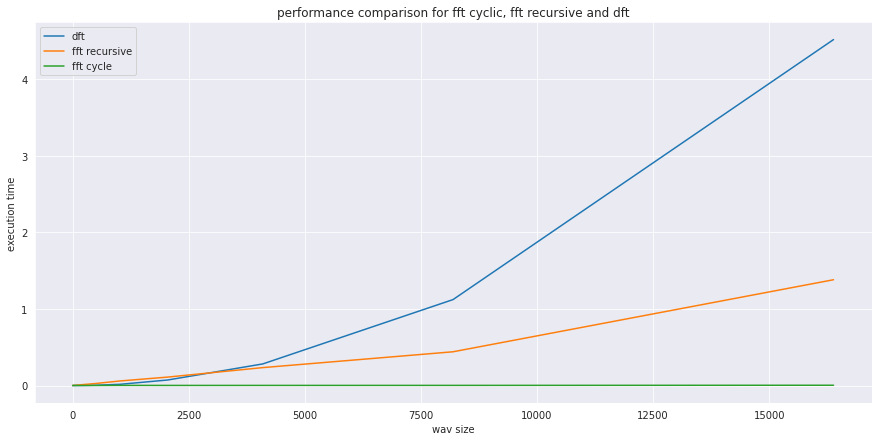

In [18]:
pwr = torch.tensor([2])
x = torch.pow(pwr, torch.arange(1, n))
sns.set_style('darkgrid')
plt.figure(figsize=[15, 7])
plt.plot(x, dft_time, label='dft')
plt.plot(x, fft_rec_time, label='fft recursive')
plt.plot(x, fft_cyc_time, label='fft cycle')
plt.legend()
plt.xlabel(r'wav size')
plt.ylabel('execution time')
plt.title('performance comparison for fft cyclic, fft recursive and dft');

In [19]:
torch.allclose(
    torch.rfft(wav[:, :2**15], signal_ndim=1),
    fft(wav[:, :2**15]),
    atol=0.0001
)

True

In [20]:
wav, sr = torchaudio.load(wav_file)
print(torch.rfft(wav, signal_ndim=1).shape)
print(fft(wav).shape)
torch.allclose(
    torch.rfft(wav, signal_ndim=1),
    fft(wav),
    atol=0.0001
)

torch.Size([1, 106575, 2])
torch.Size([1, 106575, 2])


False

# Short-time Fourier Transform (2 pts)

    Use torch.hann_window

In [21]:
def stft(wav, window_w=1024, stride=256, center=True):
  wav = wav.squeeze()
  window = torch.hann_window(window_w)
  n = wav.shape[0]
  transformed = torch.tensor([])
  shift = window_w
  
  if center == True:
    wav = F.pad(wav, (window_w // 2, window_w // 2), 'constant')
    shift = 0

  for i in range(0, n - shift + 1, stride):
    frame = wav[i : i + window_w] * window
    transformed = torch.cat([transformed, fft(frame)], dim=0)

  return transformed.transpose(1, 0).unsqueeze(0)#.type(torch.double)

In [22]:
wav_file = 'audio.wav'
wav, sr = torchaudio.load(wav_file)
wav = wav[:, : 1024]
print(wav.shape)

print(
    torch.allclose(
    torch.stft(wav, n_fft=256, hop_length=17, center=False, window=torch.hann_window(256), pad_mode='constant'),
    stft(wav, window_w=256, stride=17, center=False),
    atol=0.0001
))

print(
torch.allclose(
    torch.stft(wav, n_fft=256, hop_length=17, center=True, window=torch.hann_window(256), pad_mode='constant'),
    stft(wav, window_w=256, stride=17, center=True),
    atol=0.0001
))

torch.Size([1, 1024])
True
True


In [23]:
wav, sr = torchaudio.load(wav_file)

print(
torch.allclose(
    torch.stft(wav, n_fft=1024, hop_length=256, center=True, window=torch.hann_window(1024), pad_mode='constant'),
    stft(wav, window_w=1024, stride=256, center=True),
    atol=0.0001
))

True


# MelScale (2 pts)

[Tap on me](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [24]:
# TODO
def to_mel(points):
  return 2595.0 * math.log10(1.0 + torch.true_divide(points, 700.0))

def from_mel(points):
    return 700.0 * (10 ** (points / 2595.0) - 1.0)


class MELScale(torch.nn.Module):
  def __init__(self, n_mels=128, sample_rate=16000, f_min=300, f_max=None, n_stft=513):
    f_max = f_max if (f_max is not None) else sample_rate // 2 
    self.fmin_mel = to_mel(torch.tensor([f_min]))
    self.fmax_mel = to_mel(torch.tensor([f_max]))
    self.n_stft=n_stft
    self.n_mels = n_mels

    mel_points = torch.linspace(self.fmin_mel, self.fmax_mel, n_mels + 2)
    points = torch.floor(from_mel(mel_points)).reshape(-1, 1)

    ar = torch.linspace(0, sample_rate // 2, n_stft).expand(n_mels, n_stft)
    diff = torch.max(torch.tensor([1.0]), (points[1 : ] - points[: -1])).reshape(-1, 1)
    right = (points[2:] - ar) *  (ar > points[1:-1])  * (ar <= points[2:]) / diff[1:]
    left = (ar - points[:-2]) * (ar >= points[:-2]) * (ar <= points[1:-1]) / diff[:-1] 
    self.filters = right + left

  def forward(self, freqs):
    frames  = freqs.shape[2]
    spectrogram = torch.norm(freqs, 2, -1).squeeze().transpose(0, 1)
    res = torch.zeros((self.n_mels, frames))
    res = torch.matmul(self.filters, spectrogram.transpose(0, 1))
    return res

In [25]:
mel = MELScale(f_min=300, f_max=8000, n_stft=12, n_mels=6)

In [26]:
freqs = torch.stft(
    input=wav,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.hann_window(1024),
    center=False
)

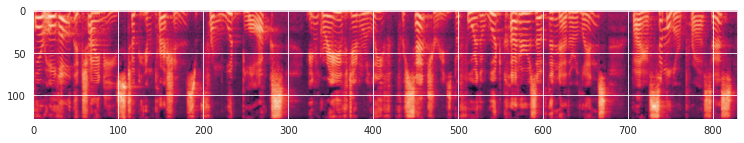

In [27]:
mel = MELScale(f_min=300, f_max=8000)
mel_res = mel.forward(freqs)
plt.figure(figsize=(17, 2))
plt.imshow(torch.log(mel_res));

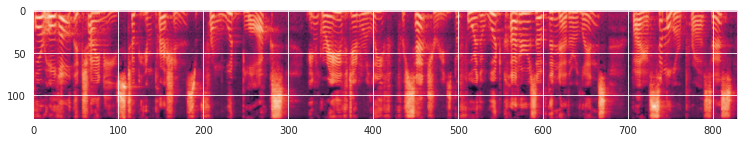

In [28]:
t_mel = torchaudio.transforms.MelScale(f_min=300, f_max=8000)
spectrogram = torch.norm(freqs, 2, -1)
t_mel_res = t_mel.forward(spectrogram)
plt.figure(figsize=(17, 2))
plt.imshow(torch.log(t_mel_res.squeeze()));

Проверяла на allclose внутреннюю функцию (создание filterbank). Оно выполняется с 0.01, из нее погрешность вылезает в MEL-scale
Сделать точнее, не переписывая код для filterbank из торчевской реализации, мне кажется, особо нельзя

#Digit classification (5 pts)

    1) Download data from google drive: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing
    
    2) Split data in 80/20 proportion. Please note that both the train and the test
    must contain all types of digits and all speakers, so carefully split the data.
    
    3) The AudioMNIST dataset1 consists of 30000 audio recordings (9.5 hours) 
    of spoken digits (0-9) in English with 50 repetitions per digit for each of the 60 different speakers.
    
    4) Build a classificator of spoken digits. You can use any neural network architecture you like.
        The minimum required quality of classificator will be announced.
    
    5) Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        

    Bonus:
        If you implement a good model or use some augmentation (or something else),
        you can expect to obtain bonuses of up to 3 points.

In [31]:
!unzip /content/drive/My\ Drive/AudioMNIST.zip;

Streaming output truncated to the last 5000 lines.
  inflating: AudioMNIST/23/7_23_34.wav  
  inflating: AudioMNIST/23/0_23_44.wav  
  inflating: AudioMNIST/23/4_23_14.wav  
  inflating: AudioMNIST/23/4_23_28.wav  
  inflating: AudioMNIST/23/9_23_17.wav  
  inflating: AudioMNIST/23/9_23_0.wav  
  inflating: AudioMNIST/23/8_23_0.wav  
  inflating: AudioMNIST/23/2_23_3.wav  
  inflating: AudioMNIST/23/6_23_43.wav  
  inflating: AudioMNIST/23/3_23_3.wav  
  inflating: AudioMNIST/23/1_23_27.wav  
  inflating: AudioMNIST/23/1_23_33.wav  
  inflating: AudioMNIST/23/6_23_9.wav  
  inflating: AudioMNIST/23/7_23_9.wav  
  inflating: AudioMNIST/23/8_23_48.wav  
  inflating: AudioMNIST/23/2_23_13.wav  
  inflating: AudioMNIST/23/2_23_12.wav  
  inflating: AudioMNIST/23/8_23_49.wav  
  inflating: AudioMNIST/23/7_23_8.wav  
  inflating: AudioMNIST/23/6_23_8.wav  
  inflating: AudioMNIST/23/1_23_32.wav  
  inflating: AudioMNIST/23/1_23_26.wav  
  inflating: AudioMNIST/23/3_23_2.wav  
  inflating: Au

In [32]:
from IPython import display as display_
import os

wav, sr = torchaudio.load('/content/AudioMNIST/07/4_07_21.wav')
print(sr)
display_.display(display_.Audio(wav, rate=sr))

16000


In [33]:
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader
from sklearn.model_selection import train_test_split

def make_dataset(directory, class_to_idx, extensions=None):
    instances = []
    #directory = os.path.expanduser(directory)
    def is_valid_file(x):
        return any(map(x.lower().endswith, extensions))
        
    for target_class in sorted(class_to_idx):
        class_index = class_to_idx[target_class]
        for root, _, fnames in sorted(os.walk(directory, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    class_index = int(fname.split('_')[0])
                    item = path, class_index
                    instances.append(item)
    return instances


class MNISTPersonDataset(DatasetFolder):
      def __init__(self, root, loader, extensions=None, transform=None,
                 target_transform=None):
        num_classes = 10
        classes, class_to_idx = torch.arange(num_classes), torch.arange(num_classes)
        samples = make_dataset(root, class_to_idx, extensions)
        
        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]
        self.transform = transform
        self.target_transform = target_transform


def make_full_dataset(root, num_dirs, transform=None,
                 target_transform=None):
   
    def loader_(filename):
        wav, sr = torchaudio.load(filename)
        return wav

    train_ds = []
    valid_ds = []
    for n_dir in range(1, num_dirs + 1):
        curr_path = os.path.join(root, f'{n_dir:02d}')
        ith_person_ds = MNISTPersonDataset(curr_path, loader_, ['wav'], 
                                         transform, target_transform)
        targets = ith_person_ds.targets
        train_idx, valid_idx= train_test_split(
          torch.arange(len(targets)),
          test_size=0.2,
          shuffle=True,
          stratify=targets)
        train_ds.append(Subset(ith_person_ds, train_idx))
        valid_ds.append(Subset(ith_person_ds, valid_idx))
    return ConcatDataset(train_ds), ConcatDataset(valid_ds)

**Sanity check**

In [34]:
dir_num = 60
root = '/content/AudioMNIST'

train_dataset, valid_dataset =  make_full_dataset(root, dir_num)

for wav, lbl in islice(train_dataset, 0, 3):
  display_.display(display_.Audio(wav, rate=16000))

for wav, lbl in islice(valid_dataset, 0, 3):
  display_.display(display_.Audio(wav, rate=16000))

In [35]:
class SameSize(nn.Module):
    def __init__(self, L=16000):
        super(SameSize, self).__init__()
        self.L = L

    def pad_audio(self, samples):
        l = samples.size()[1]
        if l >= self.L: 
          return samples
        else: 
          return F.pad(samples, (0, self.L - l), 'constant', 0)

    def chop_audio(self, samples):
        l = samples.size()[1]
        beg = torch.randint(high=l - self.L + 1, size=(1, 1))
        return samples[beg : beg + self.L]

    def forward(self, wav):
        wav = self.pad_audio(wav)
        wav = self.chop_audio(wav)
        return wav


class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.squeeze()

In [36]:
dir_num = 60
b_size = 32
seed = 1992
root = '/content/AudioMNIST'

def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    n_gpu = torch.cuda.device_count()
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

seed_torch(seed)


melspectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80,
)

same_size = SameSize()
squeeze = Squeeze()

transforms = nn.Sequential(
              same_size,
              melspectrogram,
              squeeze
            )

train_dataset, valid_dataset =  make_full_dataset(root, dir_num, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)

In [46]:
class Reshape(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # X.shape == [B, C, H, W] -> [B, H']
        return torch.flatten(x, start_dim=1)


class Inception(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        r = c_out % 3
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=c_out // 3, 
                               kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=c_in, out_channels=c_out // 3 + r, 
                               kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=c_in, out_channels=c_out // 3, 
                               kernel_size=5, padding=1)
    
    def forward(self, x):
        c1 = self.conv1(x)
        c3 = self.conv3(x)
        c5 = self.conv5(x)
        return torch.stack([c1, c2, c3], dim=1)


class Debug(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        self.n_classes = n_classes
        
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=80, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            Reshape(),
            nn.Linear(7 * 64, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, n_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.net(x)

In [58]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, classification_report
from tqdm.notebook import tqdm

def train(epochs, model, train_loader, valid_loader, 
          optimizer, scheduler, device, criterion=nn.NLLLoss()):
    for epoch in range(epochs):
        optimizer.zero_grad()
        tr_loss, val_loss = 0, 0
        for X, y in train_loader:
            model.train()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            tr_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'epoch: {epoch}, train loss: {tr_loss:.4f}')
        all_preds = torch.tensor([])
        all_labels = torch.tensor([])
        for X, y in valid_loader:
            model.eval()
            with torch.no_grad():
                X, y = X.to(device), y.to(device)
                pred = model(X)
            loss = criterion(pred, y)
            pred = torch.argmax(pred, 1)
            val_loss += loss.item()
            all_preds = torch.cat([all_preds, pred.to('cpu')])
            all_labels = torch.cat([all_labels, y.to('cpu')])
        scheduler.step(val_loss)
    print(classification_report(all_labels, all_preds))

In [59]:
print(len(train_loader), len(valid_loader))

7500 1875


In [60]:
lr = 1e-4
epochs = 5
n_classes = 10
device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNNModel(n_classes).to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, factor=0.5)

train(epochs, model, train_loader, valid_loader, optimizer, scheduler, device)

epoch: 0, train loss: 3466.4880
epoch: 1, train loss: 704.0015
epoch: 2, train loss: 320.5835
epoch: 3, train loss: 179.8310
epoch: 4, train loss: 122.6048
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6000
         1.0       1.00      1.00      1.00      6000
         2.0       1.00      1.00      1.00      6000
         3.0       1.00      0.99      1.00      6000
         4.0       1.00      1.00      1.00      6000
         5.0       1.00      1.00      1.00      6000
         6.0       1.00      1.00      1.00      6000
         7.0       1.00      1.00      1.00      6000
         8.0       1.00      1.00      1.00      6000
         9.0       1.00      1.00      1.00      6000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



Я дописала inception и хотела поиграть с аугментациями, но оно уже 1 после 4 эпох, так что видимо в следующей домашке :)

Вообще домашка объемная, но оч интересная, спасибо!